In [ ]:
# Customer Retention & Revenue Risk Analysis

##Context
#This project analyzes customer transaction data to identify early signs of customer disengagement and quantify potential revenue at risk due to declining purchase behavior.

## Objective
#- Detect customers showing declining engagement
#- Estimate revenue exposed to churn risk
#- Segment customers based on behavioral metrics
#- Provide actionable retention recommendations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
df = pd.read_csv("/content/online_retail_II.csv")




In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df_raw = df.copy()


In [6]:
df.shape

(59019, 8)

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')



In [10]:
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [11]:
df["InvoiceDate"].dtype


dtype('<M8[ns]')

In [12]:
df["Revenue"] = df["Quantity"] * df["Price"]


In [13]:
rfm = (
    df.groupby('Customer ID')
      .agg({
          'InvoiceDate': lambda x: (analysis_date - x.max()).days,
          'Invoice': 'nunique',
          'Revenue': 'sum'
      })
      .reset_index()
)

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [14]:

rfm.shape


(1191, 4)

In [15]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,4,8,181.00
1,12349.0,45,1,-24.15
2,12358.0,41,1,1429.83
3,12359.0,33,3,760.69
4,12362.0,48,1,130.00


In [16]:
recency_q50 = rfm["Recency"].quantile(0.50)
recency_q75 = rfm["Recency"].quantile(0.75)
frequency_q50 = rfm["Frequency"].quantile(0.50)


In [18]:
def seg_customer(row):
    if row["Recency"] <= recency_q50 and row["Frequency"] > frequency_q50:
        return "Loyal"
    elif row["Recency"] > recency_q75:
        return "Dormant"
    else:
        return "At Risk"

rfm["Segment"] = rfm.apply(seg_customer, axis=1)


In [19]:
seg_summary = (
    rfm.groupby("Segment")
       .agg({
           "CustomerID": "count",
           "Monetary": "sum"
       })
       .reset_index()
)

seg_summary


,Segment,CustomerID,Monetary
0,At Risk,539,212202.54
1,Dormant,275,83651.17
2,Loyal,377,654488.77


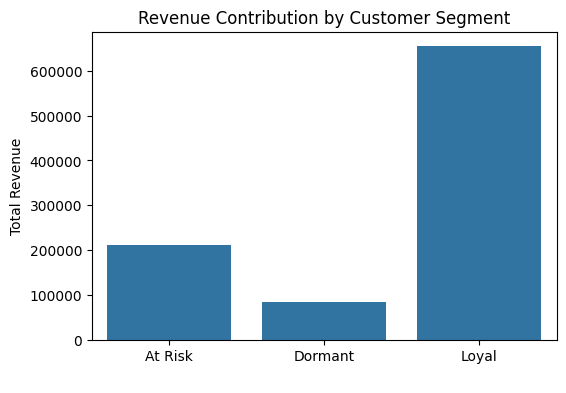

In [20]:
plt.figure(figsize=(6,4))
sns.barplot(data=seg_summary, x="Segment", y="Monetary")
plt.title("Revenue Contribution by Customer Segment")
plt.ylabel("Total Revenue")
plt.xlabel(" ")
plt.show()


In [ ]:
#logic:
#Customers were segmented using recency and frequency metrics with quantile-based thresholds.
#This approach enables explainable categorization into Loyal, At Risk ans Dormant groups,
#supporting targeted retention and reactivation strategies.
